# Food Scanner 2019

In [1]:
import warnings
from sys import stdout

import numpy as np
import pandas as pd
import pylab as plot

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import  SVR
from IPython.display import display

from module_utils.utils import head_shape, describe_plus, na_per_col, total_na_df, heatmap_isna,\
                               dist_quantitative_features, plot_mean_std, compare_plot_mean_std,\
                               plot_boxplot_outliers, violin_quantitative_features
from module_utils.preprocess import array_to_df, msc, snv, savgol_smoothing, norml
from module_utils.model_training import train_model,\
                                        compute_losses_reg,\
                                        split_train_multiple_models

sns.set(font_scale=1.2, style="darkgrid", palette="colorblind", color_codes=True)
params = {"legend.fontsize":15,
          "legend.handlelength":2}
plot.rcParams.update(params)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../All Data (human readable column names).csv', sep = ',')

In [3]:
# drop useless columns
drop_id = ['ID', 'Surface Scan Device ID', 'Juice Scan Device ID']
df = df.drop(drop_id, axis=1)

# targets columns
target_variables = df.filter(regex="Brix|Antioxidants", axis=1).columns
polyphenols_col = df.filter(regex="Polyphenols", axis=1).columns
target_variables = target_variables.append(polyphenols_col)

# Juice scans columns
juice_col = df.filter(regex="Juice", axis=1).columns
juice_target = df.filter(regex="Juice|Antioxidants|Polyphenols|Brix", axis=1).columns

# Surface scans columns
df.rename(columns={"Surface Scan 386nm":"Surface Scan 385nm"}, inplace=True)
surface_col = df.loc[:, df.columns.str.startswith("Surface")].columns
surface_target = df.filter(regex="Surface|Antioxidants|Polyphenols|Brix", axis=1).columns

# Juice and surface scans columns
surface_juice_col = surface_col.append(juice_col)
surface_juice_target = surface_juice_col.append(target_variables)

## Overview of the input variables and target variables

### 5 first lines of Surface and Juice Scans dataframe

In [4]:
head_shape(df[surface_col])
head_shape(df[juice_col].dropna())

,Surface Scan 365nm,Surface Scan 385nm,Surface Scan 450nm,Surface Scan 500nm,Surface Scan 530nm,Surface Scan 587nm,Surface Scan 632nm,Surface Scan 850nm,Surface Scan 880nm,Surface Scan 940nm
0,-59.18,-23.72,-5.215,0.49790,1.0240,6.9080,15.160,19.030,18.340,17.670
1,-191.60,-93.67,-18.970,0.02045,0.2783,7.5830,15.590,20.240,19.180,18.650
2,-125.50,-56.31,-12.560,-0.08942,1.2840,7.7250,14.050,18.110,16.580,15.560
3,-217.50,-110.30,-25.260,-2.84700,-3.2410,-2.6950,-1.539,9.315,7.702,3.101
4,-113.40,-53.12,-12.880,-1.56700,-0.9809,0.4414,2.034,12.110,12.380,11.920


(2264, 10)

,Juice Scan 365nm,Juice Scan 385nm,Juice Scan 450nm,Juice Scan 500nm,Juice Scan 530nm,Juice Scan 587nm,Juice Scan 632nm,Juice Scan 850nm,Juice Scan 880nm,Juice Scan 940nm
18,-3.52,-0.99,8.1,4.70,4.98,7.22,4.25,28.68,34.05,48.6
19,-3.46,-0.51,8.6,4.95,5.76,8.10,4.49,27.54,30.93,49.8
20,-3.53,-0.92,8.1,4.58,4.98,7.62,4.12,27.73,32.14,48.2
24,-2.10,1.70,10.9,6.51,9.02,34.78,29.49,32.20,32.68,57.0
25,-1.07,3.42,11.5,7.14,10.06,40.69,34.00,40.51,37.95,67.8


(1448, 10)

### 5 first lines of the targets dataframe

In [5]:
head_shape(df[target_variables].dropna())

,Brix,Antioxidants,Polyphenols
18,8.8,17453.50,124.78
19,5.5,18693.60,132.01
20,6.0,11900.40,90.50
24,7.5,93.73,4.33
25,7.4,107.07,3.56


(1358, 3)

## In-depth analysis
### Missing values

In [6]:
total_na_df(df)

The dataframe is made up of 68.34% missing values.


The dataframe contains a lot of NaN. We will get rid of the unnecessary columns and start to analyse the remaining columns.

In [7]:
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.8]]
display(df.shape)

(2264, 56)

The dataframe went from 121 columns to 59 columns

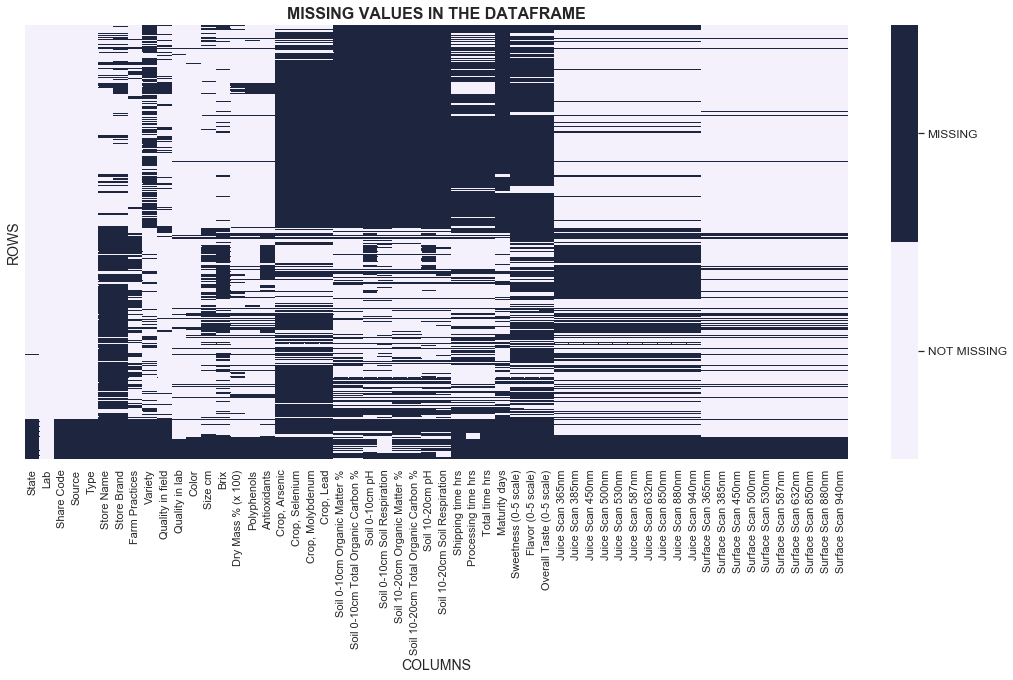

In [8]:
heatmap_isna(df)

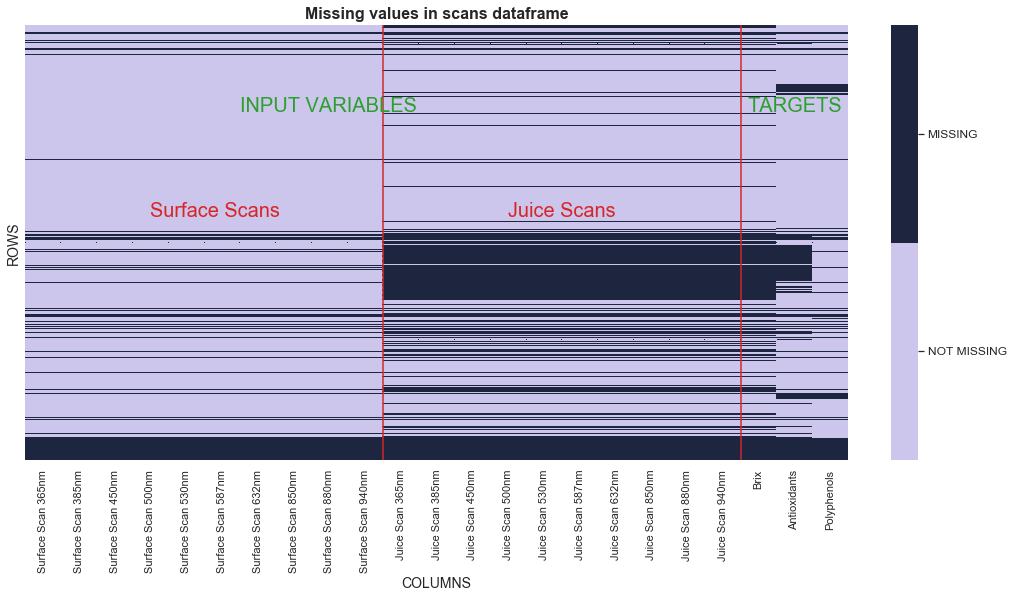

In [9]:
sns.set(font_scale=1)
cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.8, n_colors=2)
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.1}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(16,8))

sns.heatmap(df[surface_juice_target].isna(), ax=ax, yticklabels=False, cbar_ax=cbar_ax, cmap=ListedColormap(cmap), cbar_kws={'orientation': 'vertical'})

cbar_ax.set_yticklabels(['NOT MISSING', 'MISSING'], fontsize=12)
cbar_ax.yaxis.set_ticks([ 0.25, 0.75])

# set title, x and y labels
ax.set_title('Missing values in scans dataframe', fontsize=16, fontweight="bold")
ax.set_ylabel('ROWS', fontsize=14)
ax.set_xlabel('COLUMNS', fontsize=14)

# line to separate the two columns
ax.vlines(10, *ax.get_ylim(), color="tab:red")
ax.vlines(20, *ax.get_ylim(), color="tab:red")
# categoy of the two columns
ax.text(3.5,1000, 'Surface Scans', fontsize=20, color='tab:red')
ax.text(13.5,1000, 'Juice Scans', fontsize=20, color='tab:red')
ax.text(6,450, 'INPUT VARIABLES', fontsize=20, color='tab:green')
ax.text(20.2,450, 'TARGETS', fontsize=20, color='tab:green')
_ = plt.show()

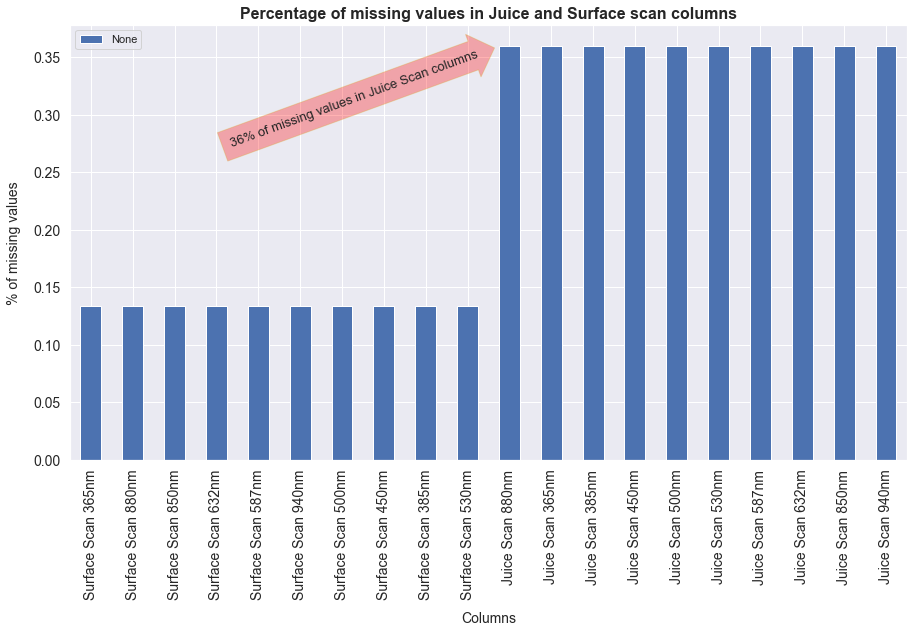

In [10]:
na_per_col(df[surface_juice_col]).plot(kind='bar',figsize=(15,8), legend=True, logy=False, fontsize=14)
plt.xlabel("Columns", fontsize=14, labelpad=12)
plt.ylabel("% of missing values", fontsize=14, labelpad=12)
plt.title("Percentage of missing values in Juice and Surface scan columns", fontsize=16, fontweight="bold")
bbox_props = dict(boxstyle="rarrow,pad=0.7", fc="RED", ec="goldenrod", lw=1, alpha=0.3)
t = plt.text(6.3, 0.314, "36% of missing values in Juice Scan columns", ha="center", va="center", rotation=20, bbox=bbox_props, fontsize=13)
bb = t.get_bbox_patch()

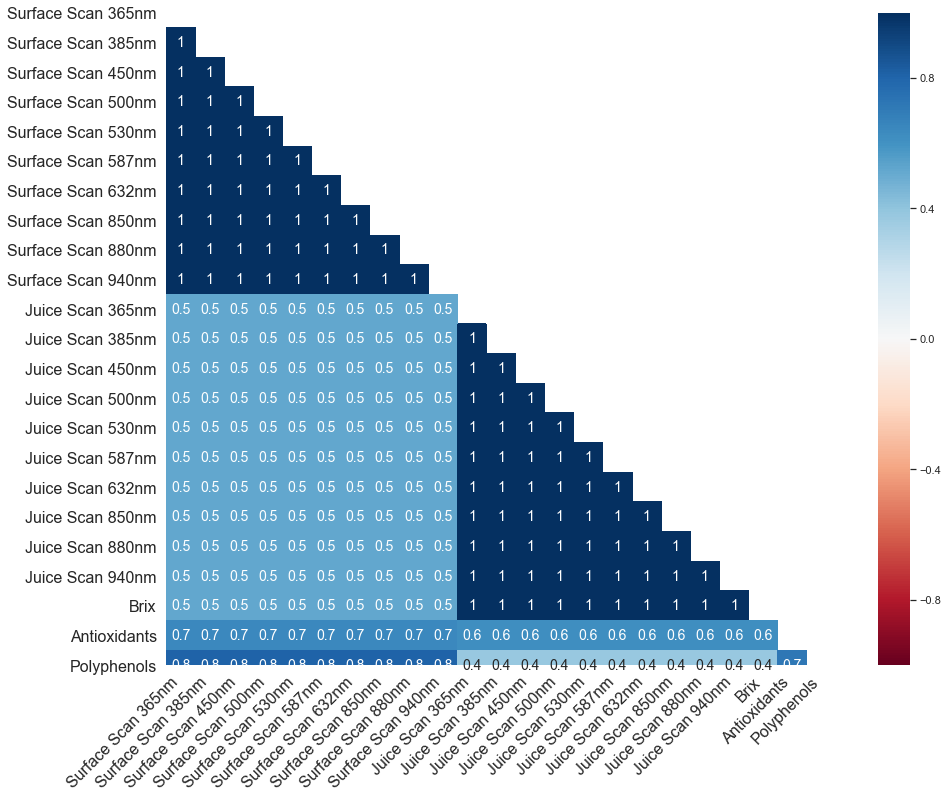

In [11]:
msno.heatmap(df[surface_juice_target], figsize=(15, 12))
_ = plt.show()

The heatmap shows the correlation between the selected columns: how strongly the presence of variable affects the presence of another. For example, Juice Scan 450 and Juice Scan 500nm are equal to 1, because this is the probability that we have the two features. We can see that the Surface Scans columns and the dependent variables (antioxidants, polyphenols) have a probability of 0.8 of complementing each other. Conversely, the probabilty to have the dependent variables (antioxidants, polyphenols) and the Juice Scan columns are 0.6 and 0.4, respectively.

## Distributions of target variables

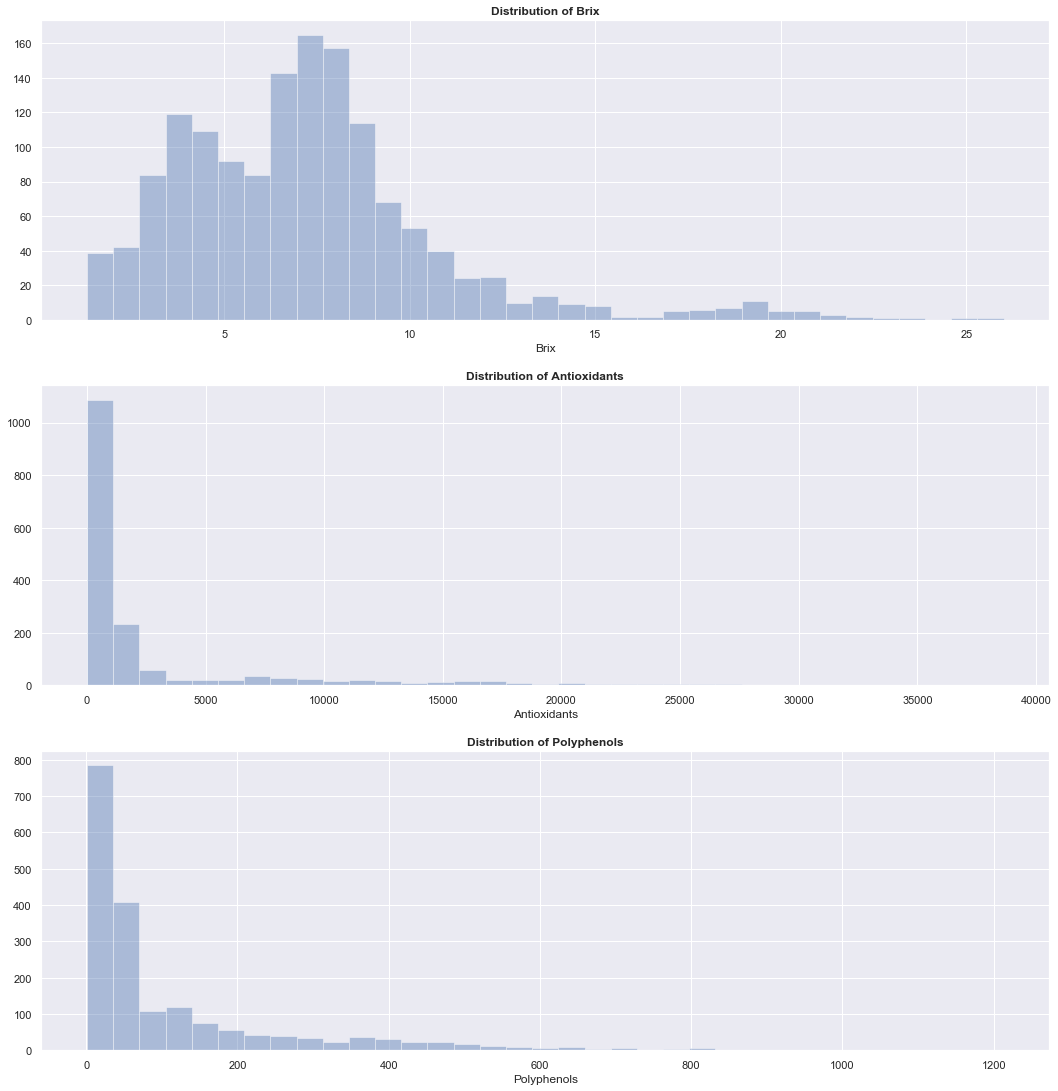

In [12]:
fig = plt.figure(figsize=(15, 15))
for i, element in enumerate(target_variables):
    fig.tight_layout(pad=1.5)
    ax = fig.add_subplot(3, 1, i+1)
    sns.distplot(df[element].dropna(), hist=True, kde=False, bins=35)
    plt.title("Distribution of {}".format(element), fontweight="bold")

### Detect outliers per type of produce

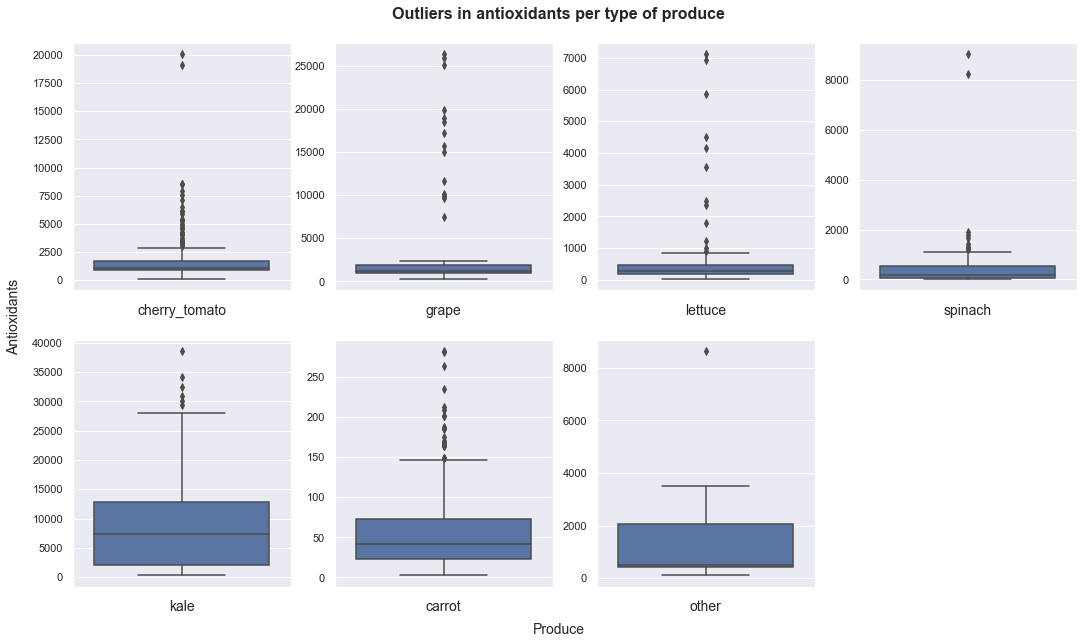

In [13]:
produce = df["Type"].unique()

plot_boxplot_outliers(dataframe=df, col="Type", cat=produce[:-1],
                      y="Antioxidants",
                      title="Outliers in antioxidants per type of produce",
                      xlabel="Produce")

## Visualization of independent variables

### Produce types

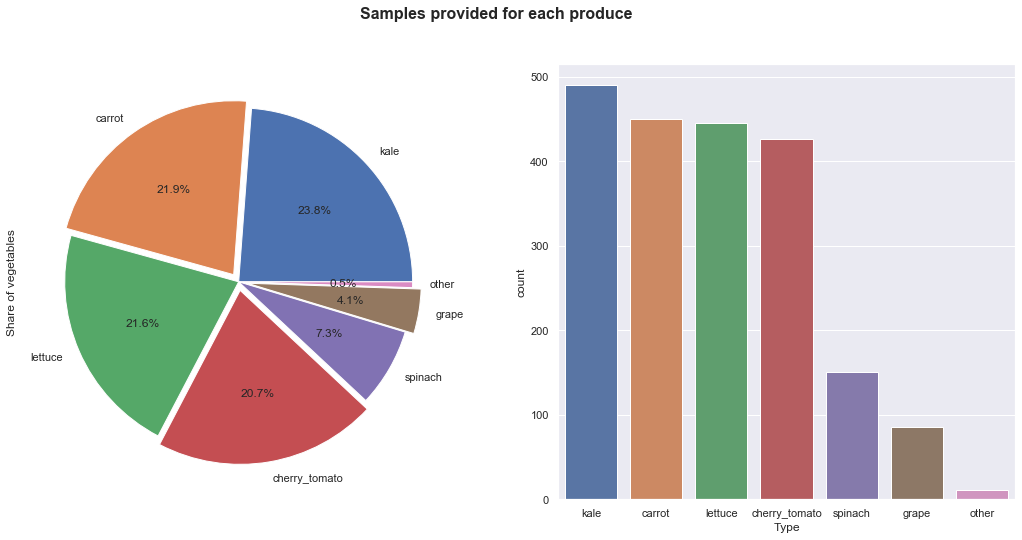

In [14]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
f.suptitle("Samples provided for each produce", fontsize=16, weight="bold")
df['Type'].value_counts().plot.pie(explode=[0,0.05,0,0.05,0,0.05,0], autopct='%1.1f%%', ax=ax[0])
ax[0].set_ylabel('Share of vegetables')
sns.countplot(x="Type", data=df, ax=ax[1], order=df['Type'].value_counts().index)
plt.show()

## Distributions of input variables

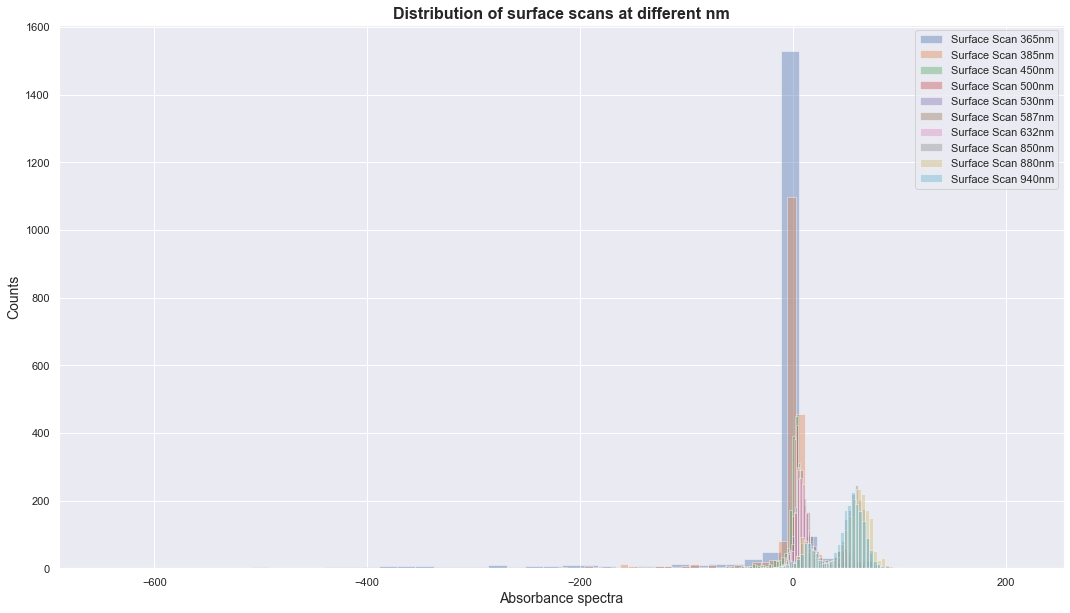

In [15]:
dist_quantitative_features(df=df, quant_feat=surface_col,
                          title="Distribution of surface scans at different nm",
                          xlabel="Absorbance spectra",
                          ylabel="Counts")

The 365 and the 385 nm surface scan values are very centered (a lot of values between -20 and 10), apart from some outliers. And the more we go up in the wavelength, the more tey are dispersed (example with 880nm and 940 nm).

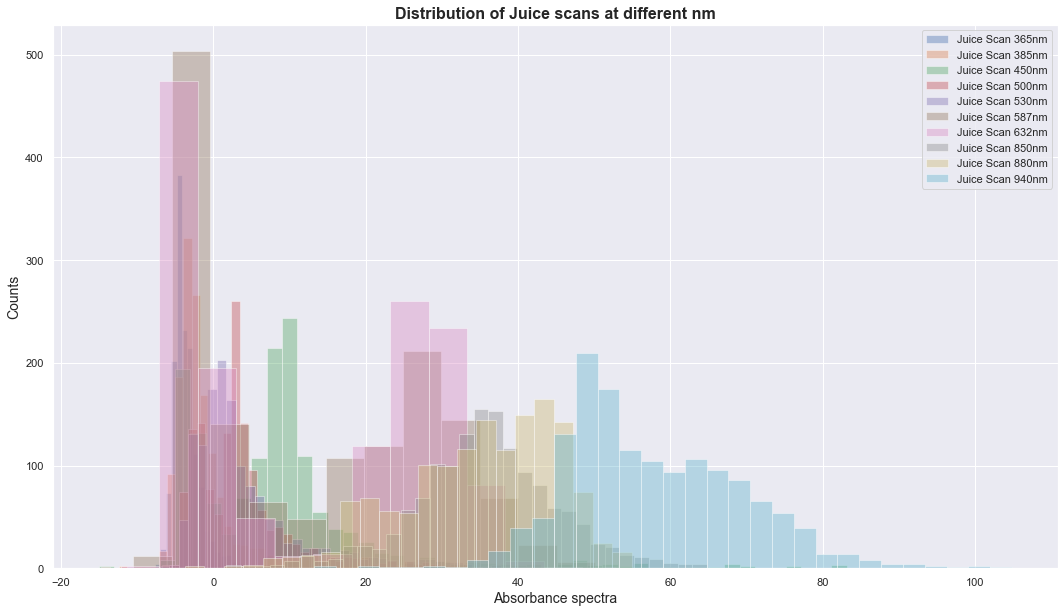

In [16]:
dist_quantitative_features(df=df, quant_feat=juice_col,
                          title="Distribution of Juice scans at different nm",
                          xlabel="Absorbance spectra",
                          ylabel="Counts")

We see roughly the same trends for Juice Scans, with a lot of centered values, then more dispersed distributions. With the difference that the juice Scan does not contain extreme outliers.

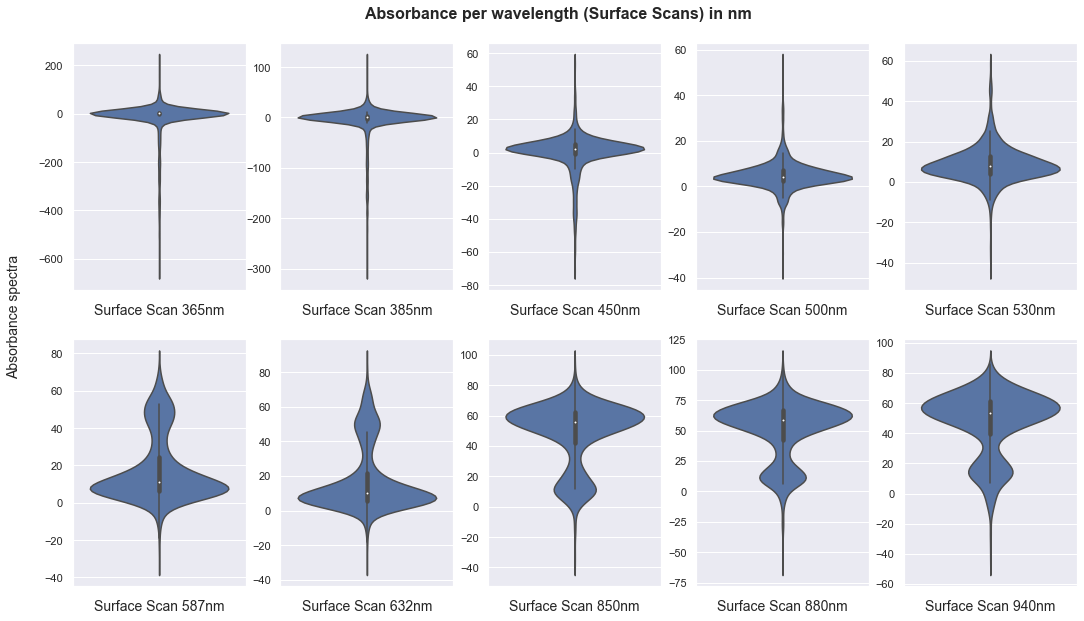

In [17]:
violin_quantitative_features(df=df, quant_feat=surface_col,
                                  title="Absorbance per wavelength (Surface Scans) in nm",
                                  ylabel="Absorbance spectra")

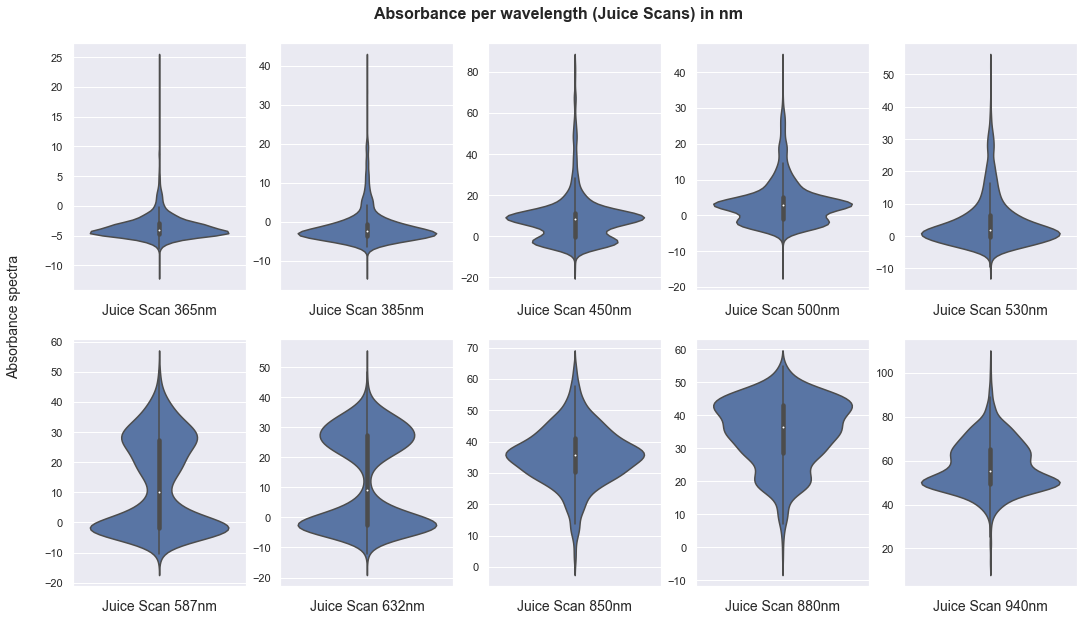

In [18]:
violin_quantitative_features(df=df, quant_feat=juice_col,
                                  title="Absorbance per wavelength (Juice Scans) in nm",
                                  ylabel="Absorbance spectra")

### Comparison mean and standard deviation of the two features scans - Surface and Juice Scans

In [19]:
df_juice = df[juice_col].rename(columns=lambda col: str(col[11:14]), inplace=False)
df_surface = df[surface_col].rename(columns=lambda col: str(col[13:16]), inplace=False)
wavelength = df_juice.columns

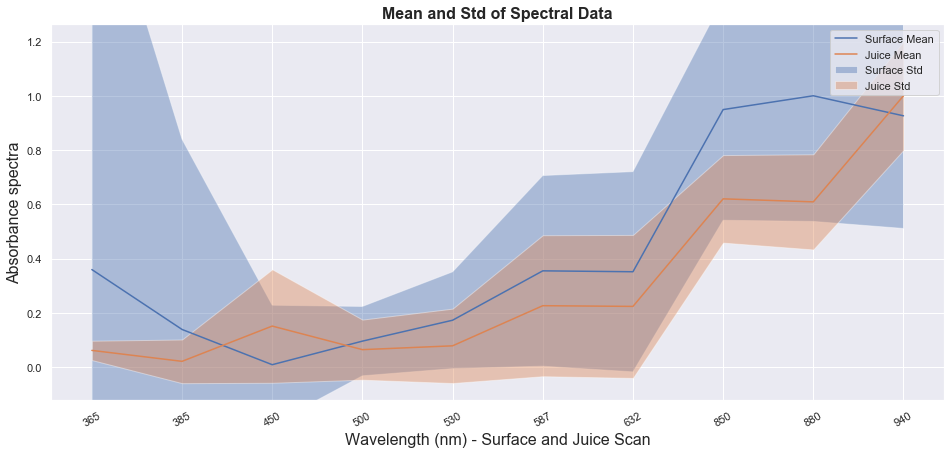

In [20]:
compare_plot_mean_std(df1 = df_surface, df2 = df_juice,
                      xlabel="Wavelength (nm) - Surface and Juice Scan", ylabel="Absorbance spectra", title="Mean and Std of Spectral Data",
                      label_mean="Surface Mean", label_std="Surface Std", label_mean2="Juice Mean", label_std2="Juice Std", figsize=(16,6))

## Baseline models for Surface scans
We are going to train several naive models without applying pre-processing methods to the input data - these anive models will serve as a basis for us to measure the impact of preprocessing methods on the input data. These methods of pre-processing aim to reduce noises and isolate important spectral characteristics.

- #### Columns: Surface Scans
- #### Type: Kale
- #### Target: Polyphenols

In [21]:
# init model objects
lin_regression = LinearRegression()
pls = PLSRegression(n_components=5)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1, coef0=1)
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
# create list of models used for training - for columns name
models_name = ['Linear regression', 'Partial least squares', 'SVR polynomial', 'RF regressor']

In [22]:
x = df[df["Type"]=="kale"][surface_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().iloc[:,1:11].values
y = df[df["Type"]=="kale"][surface_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().iloc[:,:1].values

In [23]:
naive_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x, y=y, col_name=models_name)
naive_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,141.21,139.467,148.311,129.902
MSE,32592.8,32351.9,41992.9,29893.5
R2,0.104056,0.110677,-0.154345,0.178256
RMSE,180.535,179.866,204.922,172.897


## Preprocessing and trainings
Le but du pré-traitement des données est d'éliminerr ou de minimiser la variabilité des longueurs d'ondes.
http://www.models.life.ku.dk/sites/default/files/preproNIR.pdf

### Multiplicative Scatter Correction
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

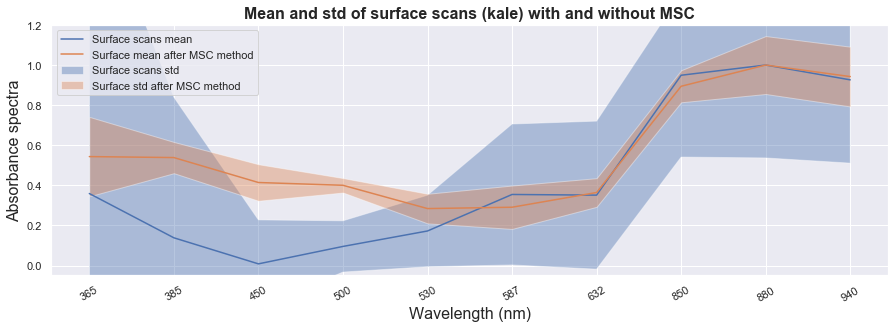

In [24]:
# Apply MSC method on our input variables
x_msc, msc_df = array_to_df(x, msc,
           index=df[df["Type"]=="kale"][surface_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=msc_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without MSC",
                     label_mean="Surface scans mean", label_std="Surface scans std", label_mean2="Surface mean after MSC method", label_std2="Surface std after MSC method")

In [25]:
def n_test_plot_mean_std(*args, xlabel, ylabel, title, label_mean="Mean", label_std="Std", figsize=(15,4)):
    """
    Plot multiple mean std plots in one graph
    """
    list_df_mean_std = []
    fig, ax = plt.subplots(1, figsize=figsize)
    plt.subplots_adjust(bottom=0.01)
    for df in args:
        df_describe = describe_plus(df)
        df_mean_std = abs(df_describe[['mean']]/df_describe['mean'].max())
        df_mean_std['std'] = df_describe[['std']]/df_describe['mean'].max()
        mean = df_mean_std['mean']
        std = df_mean_std['std']
        list_df_mean_std.append(df)
        
        plt.fill_between(np.arange(df_mean_std.shape[0]), (mean-std), (mean + std), alpha=.4, label=label_std)
        plt.plot(mean, label=label_mean)
    
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    plt.title(title, fontsize=16, weight="bold")

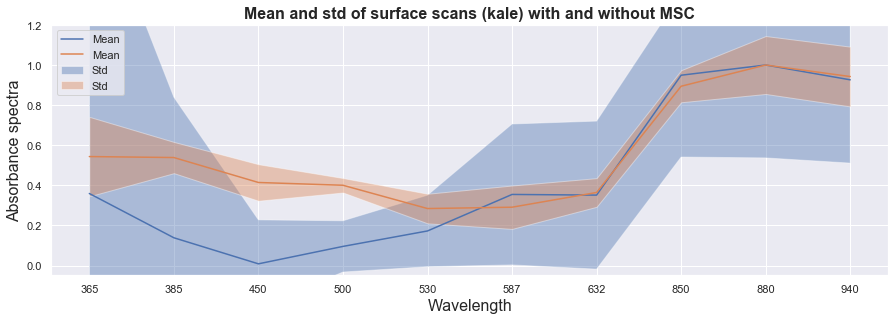

In [26]:
n_test_plot_mean_std(df_surface, msc_df, xlabel="Wavelength", ylabel="Absorbance spectra",title="Mean and std of surface scans (kale) with and without MSC")

In [27]:
msc_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_msc, y=y, col_name=models_name)
msc_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,139.87,140.165,137.342,138.743
MSE,32135.2,32180.2,35982.8,32144.2
R2,0.116635,0.115398,0.0108678,0.116386
RMSE,179.263,179.388,189.691,179.288


### Standard Normal Variate
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

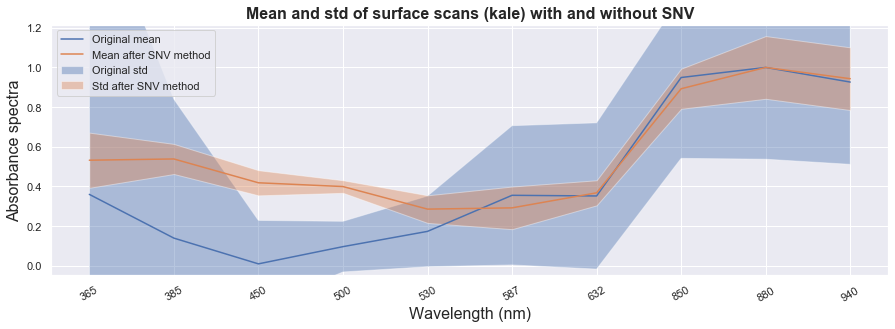

In [28]:
# Apply SNV method on our input variables
x_snv, snv_df = array_to_df(x, snv,
           index=df[df["Type"]=="kale"][surface_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=snv_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without SNV",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after SNV method", label_std2="Std after SNV method")

In [29]:
snv_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_snv, y=y, col_name=models_name)
snv_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,140.555,139.887,139.944,141.985
MSE,32080.8,32093.2,37624.8,32975
R2,0.11813,0.11779,-0.0342704,0.0935495
RMSE,179.111,179.146,193.971,181.59


### Savitsky-Golay
https://nirpyresearch.com/savitzky-golay-smoothing-method/

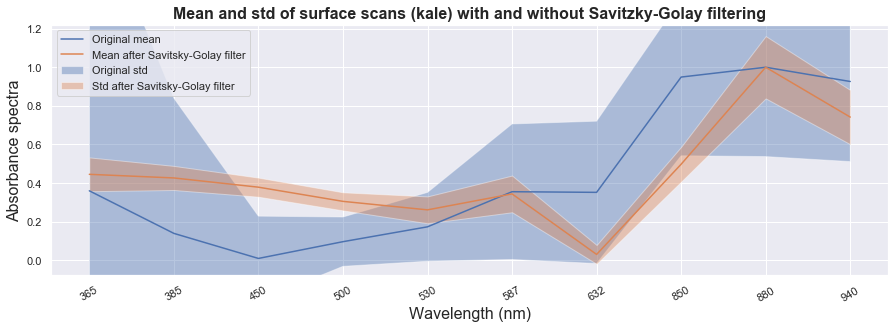

In [30]:
# Apply svagol_filter method on our input variables
x_savgol, savgol_df = array_to_df(x, savgol_smoothing,
           index=df[df["Type"]=="kale"][surface_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=savgol_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Savitzky-Golay filtering",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after Savitsky-Golay filter", label_std2="Std after Savitsky-Golay filter")

In [31]:
savgol_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_savgol, y=y, col_name=models_name)
savgol_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,140.219,140.477,137.183,142.992
MSE,32416.3,33061.7,33922.9,33039.2
R2,0.108908,0.0911647,0.0674925,0.0917839
RMSE,180.045,181.829,184.182,181.767


### Spectral normalisation

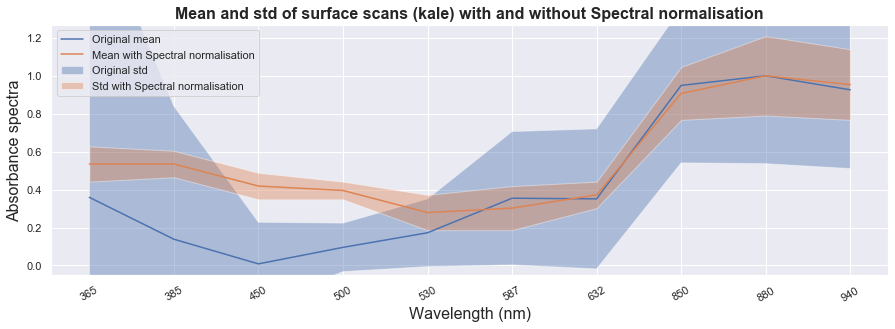

In [32]:
# Apply Spectral normalisation method on our input variables
x_norml, norml_df = array_to_df(x, norml,
           index=df[df["Type"]=="kale"][surface_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=norml_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Spectral normalisation",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean with Spectral normalisation", label_std2="Std with Spectral normalisation")

In [33]:
norml_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_norml, y=y, col_name=models_name)
norml_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,140.345,140.543,156.002,150.606
MSE,32522.2,32780,44705.4,36490.4
R2,0.105996,0.0989091,-0.228907,-0.00308691
RMSE,180.339,181.053,211.436,191.025


## Performance summary of models with and without preprocessing on Surface scans
#### Metric : MSE

In [34]:
df_list = [naive_models_df, msc_models_df, snv_models_df, savgol_models_df, norml_models_df]
mse_df = pd.DataFrame()
for df_listed in df_list:
    df_listed = df_listed.iloc[1].to_frame()
    mse_df = pd.concat([mse_df, df_listed], axis=1)
cols_name = ["No preprocessing", "MSC", "SNV", "Savgol filter", "Spectral norml"]
mse_df.columns = [col for col in cols_name]

In [35]:
display(mse_df.style.highlight_min(color="darkgreen", axis=1))
display(mse_df.style.highlight_min(color="darkgreen", axis=0))

,No preprocessing,MSC,SNV,Savgol filter,Spectral norml
Linear regression,32592.8,32135.2,32080.8,32416.3,32522.2
Partial least squares,32351.9,32180.2,32093.2,33061.7,32780
SVR polynomial,41992.9,35982.8,37624.8,33922.9,44705.4
RF regressor,29893.5,32144.2,32975,33039.2,36490.4


,No preprocessing,MSC,SNV,Savgol filter,Spectral norml
Linear regression,32592.8,32135.2,32080.8,32416.3,32522.2
Partial least squares,32351.9,32180.2,32093.2,33061.7,32780
SVR polynomial,41992.9,35982.8,37624.8,33922.9,44705.4
RF regressor,29893.5,32144.2,32975,33039.2,36490.4


## Baseline models for Juice scans
We are going to train several naive models without applying pre-processing methods to the input data - these anive models will serve as a basis for us to measure the impact of preprocessing methods on the input data. These methods of pre-processing aim to reduce noises and isolate important spectral characteristics.

- #### Columns: Juice Scans
- #### Type: Kale
- #### Target: Polyphenols

In [36]:
x = df[df["Type"]=="kale"][juice_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().iloc[:,1:11].values
y = df[df["Type"]=="kale"][juice_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().iloc[:,:1].values

In [37]:
naive_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x, y=y, col_name=models_name)
naive_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,104.785,102.523,119.898,98.4242
MSE,17838.9,16187.5,29046.8,16241.6
R2,0.389041,0.4456,0.00518782,0.443747
RMSE,133.562,127.23,170.431,127.443


## Preprocessing and trainings
http://www.models.life.ku.dk/sites/default/files/preproNIR.pdf

### Multiplicative Scatter Correction
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

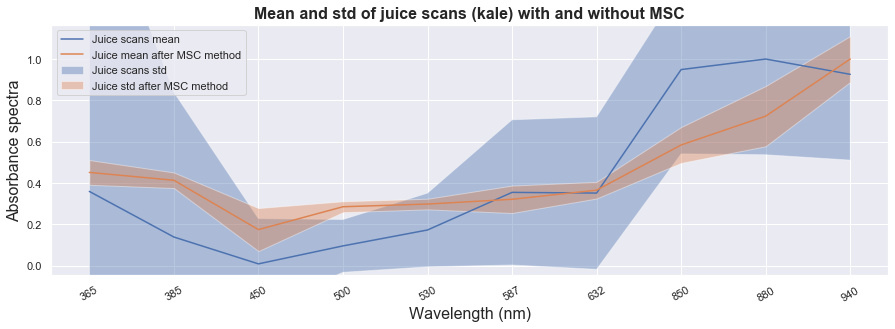

In [38]:
# Apply MSC method on our input variables
x_msc, msc_df = array_to_df(x, msc,
           index=df[df["Type"]=="kale"][juice_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=msc_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without MSC",
                     label_mean="Juice scans mean", label_std="Juice scans std", label_mean2="Juice mean after MSC method", label_std2="Juice std after MSC method")

In [39]:
msc_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_msc, y=y, col_name=models_name)
msc_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,101.428,102.23,109.38,101.747
MSE,15570.2,16753.2,18289.8,18081.6
R2,0.46674,0.426224,0.3736,0.38073
RMSE,124.781,129.434,135.24,134.468


### Standard Normal Variate
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

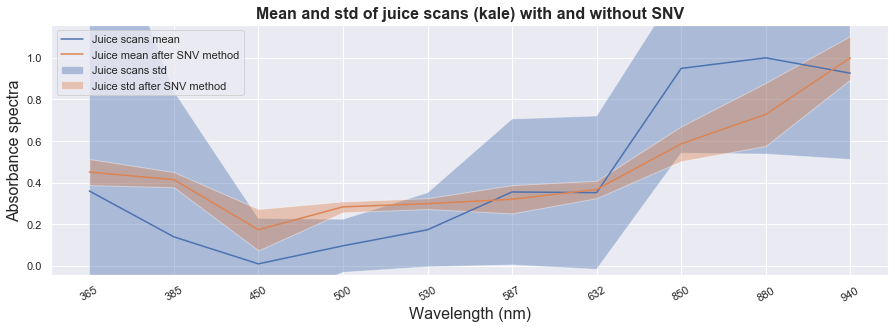

In [40]:
# Apply SNV method on our input variables
x_snv, snv_df = array_to_df(x, snv,
           index=df[df["Type"]=="kale"][juice_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=snv_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without SNV",
                     label_mean="Juice scans mean", label_std="Juice scans std", label_mean2="Juice mean after SNV method", label_std2="Juice std after SNV method")

In [41]:
snv_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_snv, y=y, col_name=models_name)
snv_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,103.561,101.669,135.376,111.987
MSE,16353.2,16484.7,27252,21754.8
R2,0.439926,0.435421,0.0666552,0.254927
RMSE,127.88,128.393,165.082,147.495


### Savitsky-Golay
https://nirpyresearch.com/savitzky-golay-smoothing-method/

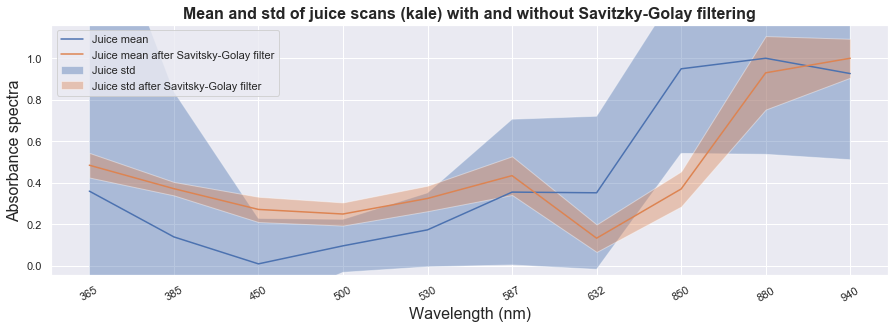

In [42]:
# Apply svagol_filter method on our input variables
x_savgol, savgol_df = array_to_df(x, savgol_smoothing,
           index=df[df["Type"]=="kale"][juice_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=savgol_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without Savitzky-Golay filtering",
                     label_mean="Juice mean", label_std="Juice std", label_mean2="Juice mean after Savitsky-Golay filter", label_std2="Juice std after Savitsky-Golay filter")

In [43]:
savgol_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_savgol, y=y, col_name=models_name)
savgol_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,100.951,123.157,109.504,113.269
MSE,15991.7,23025.7,18338.4,18732.4
R2,0.452307,0.2114,0.371935,0.35844
RMSE,126.458,151.742,135.419,136.866


### Spectral normalisation

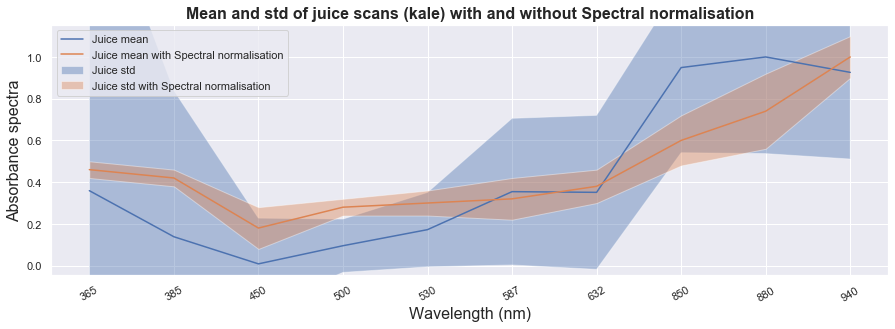

In [44]:
# Apply Spectral normalisation method on our input variables
x_norml, norml_df = array_to_df(x, norml,
           index=df[df["Type"]=="kale"][juice_target].drop(['Brix', 'Antioxidants'], axis=1).dropna().index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=norml_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without Spectral normalisation",
                     label_mean="Juice mean", label_std="Juice std", label_mean2="Juice mean with Spectral normalisation", label_std2="Juice std with Spectral normalisation")

In [45]:
norml_models_df = split_train_multiple_models(lin_regression, pls, svr_poly, rf_regressor, x=x_norml, y=y, col_name=models_name)
norml_models_df.style.highlight_min(color="darkorange", axis=1)

,Linear regression,Partial least squares,SVR polynomial,RF regressor
MAE,101.441,102.649,143.465,101.556
MSE,15996.4,16640.6,29599.7,16033.2
R2,0.452145,0.430083,-0.0137497,0.450885
RMSE,126.477,128.998,172.046,126.622


## Performance summary of models with and without preprocessing on Juice scans
#### Metric : MSE

In [46]:
df_list = [naive_models_df, msc_models_df, snv_models_df, savgol_models_df, norml_models_df]
mse_df = pd.DataFrame()
for df in df_list:
    df = df.iloc[1].to_frame()
    mse_df = pd.concat([mse_df, df], axis=1)
cols_name = ["No preprocessing", "MSC", "SNV", "Savgol filter", "Spectral norml"]
mse_df.columns = [col for col in cols_name]
mse_df.columns = pd.MultiIndex.from_product([['MSE metric'], mse_df.columns])

In [47]:
display(mse_df.style.highlight_min(color="darkgreen", axis=1))
display(mse_df.style.highlight_min(color="darkgreen", axis=0))

In [48]:
def process_n_train(*args, df, y, preprocess, models_name):
    """
    Apply smoothing method on df.values, takes transformed data as input to models

    Parameters
    ----------
    *args : list of objects
    df :
    y : numpy.darray
        target variable - variable to predict
    preprocess : object
        object used to transform data
    models_name : list of strings
        columns of the new dataframe - list of models name

    Returns
    -------
    Dataframe of metrics, plot mean std of transformed data
    """
    index = df.index
    columns = df.columns
    x = df.values

    # apply transformation on x values
    transformed_data = preprocess(x)
    transformed_df = pd.DataFrame(
        data=transformed_data, index=index, columns=columns)

    # plot mean and standard deviation of transformed input data (after preprocessing)
    plot_mean_std(transformed_df)

    # train test split data and enter in list of models (object) *args
    x_train, x_test, y_train, y_test = train_test_split(
        transformed_data, y, test_size=0.30, random_state=42)

    # create a dataframe which groups together the metrics of all the prediction models
    final_df = pd.DataFrame()
    for model in args:
        # enter x_train and y_train in each of the models
        train_model(model, x_train, y_train)
        dict_losses = compute_losses_reg(model, x_test, y_test)
        df = pd.DataFrame.from_dict({"df": dict_losses})
        final_df = pd.concat([final_df, df], axis=1)
    final_df.columns = [col for col in models_name]
    return final_df